In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the dataset
dataset_path = "/content/drive/MyDrive/Research/NLP/Project/Identifying_offensive_text_with_Bengla_language_from_social_media.xlsx"
df = pd.read_excel(dataset_path)

length_yes = len(df[df.threat_label=='yes'])
length_no =len(df[df.threat_label=='no'])
print(length_yes, length_no)

947 3976


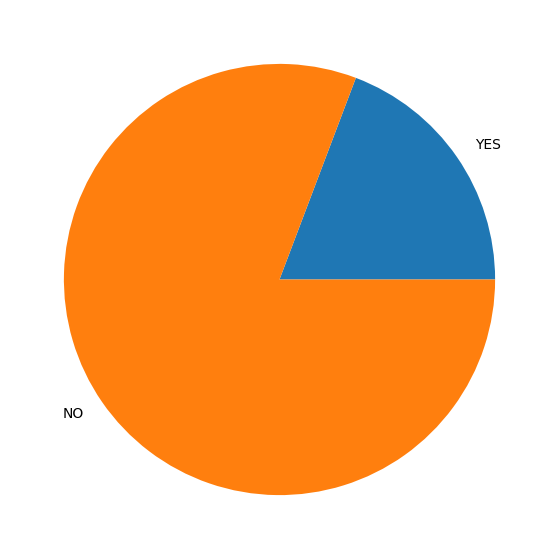

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


stas = ['YES', 'NO']

data = [length_yes, length_no]

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = stas)


plt.show()

In [ ]:
df.dtypes

comment         object
Category        object
threat_label    object
label           object
dtype: object

In [ ]:
df.shape

(4923, 4)

In [ ]:
df.columns

Index(['comment', 'Category', 'threat_label', 'label'], dtype='object')

In [ ]:
df['Category'].unique()

array(['Actor', 'Singer', 'Sports', 'Politician', 'Social', 'actor',
       'politician', 'sports', 'social', 'singer'], dtype=object)

In [ ]:
df['threat_label'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
df['label'].unique()

array(['troll', 'not bully', 'religious', 'sexual', 'threat'],
      dtype=object)

In [ ]:
wrong_lable = df.loc[df['threat_label'] == 'Male']
print(wrong_lable)

Empty DataFrame
Columns: [comment, Category, threat_label, label]
Index: []


In [ ]:
null_mask = df.isnull().any(axis=1)
null_rows = null_mask.to_numpy().nonzero()[0]
# the reason is to add 2 is first of all it start counting to get the index value form 0 and there is a column level with is not need
print(null_rows+2)

[]


In [ ]:
df.isnull().sum()

comment         0
Category        0
threat_label    0
label           0
dtype: int64

In [ ]:
import warnings
warnings.filterwarnings("ignore",
    "Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access", 
    UserWarning)

df.threat_label = df.threat_label.replace({'yes': 1, 'no': 0})

In [ ]:
df = df.drop('Category', axis=1)
df = df.drop('label', axis=1)

In [ ]:
df.head(5)

,comment,threat_label
0,তোমার বিশ্বাসের সাথে আমাদের কোন যায় আসেনা।তুমি...,0
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছিলেন,0
2,অরে বাবা এই টা কোন পাগল,0
3,ক্যাপ্টেন অফ বাংলাদেশ,0
4,পটকা মাছ,0


In [ ]:
df['threat_label'] = pd.to_numeric(df['threat_label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4923 entries, 0 to 4922
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment       4923 non-null   object
 1   threat_label  4923 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 77.0+ KB


In [ ]:
df.head(5)

,comment,threat_label
0,তোমার বিশ্বাসের সাথে আমাদের কোন যায় আসেনা।তুমি...,0
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছিলেন,0
2,অরে বাবা এই টা কোন পাগল,0
3,ক্যাপ্টেন অফ বাংলাদেশ,0
4,পটকা মাছ,0


In [ ]:
# Get the maximum length of text in the 'text_column' column
max_length = df['comment'].str.len().max()

print('Maximum text length:', max_length)

Maximum text length: 1296


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random
import time

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', truncation=True)

class BanglaNewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.comment
        self.targets = self.data.threat_label
        self.max_length = max_length
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        labels = self.targets[index]
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_tensors='pt'
            
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        return ids.squeeze(), mask.squeeze(), token_type_ids.squeeze(), labels

max_length = 256
batch_size = 16


In [ ]:
train_data, test_data = train_test_split(df, test_size=0.10, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.20, random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_dataset = BanglaNewsDataset(train_data, tokenizer, max_length)
val_dataset = BanglaNewsDataset(val_data, tokenizer, max_length)
test_dataset = BanglaNewsDataset(test_data, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
class BanglaNewsClassifier(torch.nn.Module):
    def __init__(self, num_classes):
        super(BanglaNewsClassifier, self).__init__()
        self.bert = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=num_classes)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_classes)
        # print("\n\n\n\n", self.bert.config.hidden_size, "\n\n\n\n\n")
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        return outputs.logits

In [ ]:
num_classes = len(df.threat_label.unique())
# print(num_classes)
model = BanglaNewsClassifier(num_classes)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [ ]:
import torch.optim as optim

train_losses = []
val_lossess = []
train_accus = []
val_accus = []

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the number of epochs and start training
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        input_ids = data[0].to(device)
        input_mask = data[1].to(device)
        input_token = data[2].to(device)
        labels = data[3].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(input_ids, input_mask, input_token)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()




    # Print statistics every epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f'Train - Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%')
    train_losses.append(epoch_loss)
    train_accus.append(epoch_acc)

        
    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # Get the inputs and labels
            input_ids = data[0].to(device)
            input_mask = data[1].to(device)
            input_token = data[2].to(device)
            labels = data[3].to(device)
            
            # Forward pass
            outputs = model(input_ids, input_mask, input_token)
            loss = criterion(outputs, labels)

            # Compute statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print statistics for the validation loop
    val_loss = running_loss / len(val_loader)
    val_accs = 100 * correct / total
    print(f'Validation - Epoch {epoch+1}/{num_epochs} - Loss: {val_loss:.4f} - Accuracy: {val_accs:.2f}%')
    val_lossess.append(val_loss)
    val_accus.append(val_accs)

Train - Epoch 1/5 - Loss: 0.4613 - Accuracy: 81.19%
Validation - Epoch 1/5 - Loss: 0.4206 - Accuracy: 82.27%
Train - Epoch 2/5 - Loss: 0.3734 - Accuracy: 84.50%
Validation - Epoch 2/5 - Loss: 0.3725 - Accuracy: 83.41%
Train - Epoch 3/5 - Loss: 0.2993 - Accuracy: 87.47%
Validation - Epoch 3/5 - Loss: 0.4353 - Accuracy: 82.84%
Train - Epoch 4/5 - Loss: 0.2146 - Accuracy: 91.35%
Validation - Epoch 4/5 - Loss: 0.4794 - Accuracy: 82.84%
Train - Epoch 5/5 - Loss: 0.1288 - Accuracy: 95.53%
Validation - Epoch 5/5 - Loss: 0.5891 - Accuracy: 82.50%


In [ ]:
# # Save the trained model weights
# torch.save(model.state_dict(), 'model_weights.pth')

# # Load the saved model weights
# model.load_state_dict(torch.load('model_weights.pth'))

# Evaluation Graph

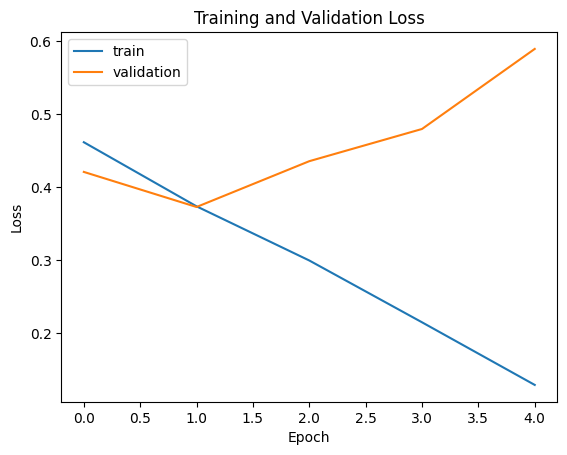

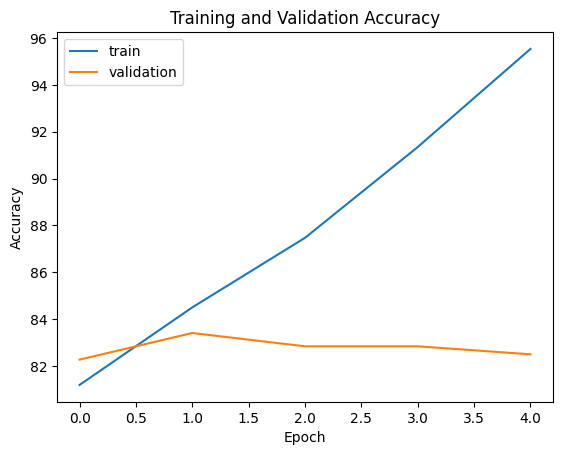

In [ ]:
import matplotlib.pyplot as plt
  
# Plot the loss curve
plt.plot(train_losses, label='train')
plt.plot(val_lossess, label='validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(train_accus, label='train')
plt.plot(val_accus, label='validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Put the model in evaluation mode
model.eval()

# Define empty lists to store predictions and actual labels
predictions = []
actual_labels = []

# Turn off gradient computation to speed up inference
with torch.no_grad():
    for data in test_loader:
        # Get the inputs and labels
        input_ids = data[0].to(device)
        input_mask = data[1].to(device)
        input_token = data[2].to(device)
        labels = data[3].to(device)

        # Make predictions
        outputs = model(input_ids, input_mask, input_token)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and actual labels
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(actual_labels, predictions)
print(cm)

[[365  32]
 [ 47  36]]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(actual_labels, predictions)
precision = precision_score(actual_labels, predictions, average='weighted')
recall = recall_score(actual_labels, predictions, average='weighted')
f1 = f1_score(actual_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8354
Precision: 0.8243
Recall: 0.8354
F1-score: 0.8288


# Preparing Model for real-life testing

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_model = BanglaNewsClassifier(num_classes=2).to(device)
# Load the saved model weights
# save_model.load_state_dict(torch.load('/content/drive/MyDrive/model_weights.pth'))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [ ]:
def predict_class(save_model, tokenizer, device, sentence):
    # Tokenize the input sentence
    encoded_sent = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt'
    )

    # Move the input to the correct device
    input_ids = encoded_sent['input_ids'].to(device)
    attention_mask = encoded_sent['attention_mask'].to(device)
    token_type_ids = encoded_sent['token_type_ids'].to(device)

    # Make the prediction
    with torch.no_grad():
        outputs = save_model(input_ids, attention_mask, token_type_ids)
        predictions = torch.argmax(outputs, dim=1)
    
    return predictions.item()

In [ ]:
sentence = str(input())
predicted_class = predict_class(save_model, tokenizer, device, sentence)
# print(type(predicted_class))
if predicted_class == 1:
  print("This sentence is threatful!!!")
else:
  print("This sentence is not threatful...!")

আজকের খবর: বৃষ্টির কারণে ঢাকায় জলবায়ু উন্নয়ন সফর থাম
This sentence is not threatful...!
